# Table of Contents

1. [Introduction](#model-training-with-dbt-integration)
2. [Load Data from dbt](#1-load-data-from-dbt)
3. [Split Data into Training and Testing Sets](#2-split-data-into-training-and-testing-sets)
4. [Build the Preprocessing and Modeling Pipeline](#3-build-the-preprocessing-and-modeling-pipeline)
   - [What is FeatureEngineer and Why Use It?](#what-is-featureengineer-and-why-use-it)
5. [Hyperparameter Tuning with GridSearchCV](#4-hyperparameter-tuning-with-gridsearchcv)
6. [Save the Best Model](#5-save-the-best-model)
7. [Next Steps and Limitations](#next-steps-and-limitations)

# Model Training with dbt Integration

This notebook trains a fraud detection model for auto insurance using the data prepared by the dbt pipeline. It connects to the DuckDB database, loads the final feature table, and then trains and tunes a scikit-learn model pipeline that includes steps for preprocessing and feature engineering. The notebook also evaluates the model's performance, visualizes key metrics, and saves the best pipeline. The saved model pipeline can be loaded later for automated fraud prediction on new claims data, enabling seamless deployment in production systems or integration with APIs for real-time inference.

## 1. Load Data from dbt

Connect to the DuckDB database generated by the dbt run and load the `fct_claims_predictions` table. 

In [4]:
import duckdb
import pandas as pd
import numpy as np

# Connect to the DuckDB database created by dbt
db_path = 'dbt_project/fraud_detection_db.duckdb'
try:
    con = duckdb.connect(database=db_path, read_only=True)
    
    # Query the fct_claims_predictions table
    query = "SELECT * FROM fct_claims_predictions"
    df = con.execute(query).fetchdf()
    
    con.close()
    
    # The 'fraud_reported' column from dbt is 'Y'/'N'. Convert it to 1/0 for modeling.
    if 'fraud_reported' in df.columns:
        df['fraud_reported'] = df['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)
    
    print(f"Data loaded successfully from '{db_path}'.")
    print(f"Loaded {len(df)} records.")
    display(df.info())

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure you have run the dbt project successfully (`dbt run`) before running this notebook.")


Data loaded successfully from 'dbt_project/fraud_detection_db.duckdb'.
Loaded 1000 records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int32  
 1   age                          1000 non-null   int32  
 2   policy_number                1000 non-null   int32  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int32  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int32  
 9   insured_zip                  1000 non-null   int32  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null 

None

### Data Preview
Let's take a quick look at the loaded data, summary statistics, and class distribution.

In [6]:
# Preview first few rows
display(df.head())

# Show summary statistics
print("Summary statistics:")
display(df.describe(include='all'))

# Show class distribution for the target variable
if 'fraud_reported' in df.columns:
    print('Class distribution:')
    print(df['fraud_reported'].value_counts())

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,429,56,804410,1998-12-12,OH,250/500,1000,1127.89,6000000,460722,...,YES,39480,6580,6580,26320,Suburu,Forrestor,2002,0,NaN
1,124,32,756054,1992-06-06,IL,250/500,1000,1198.15,0,447925,...,YES,73560,12260,12260,49040,BMW,X5,1995,0,NaN
2,87,27,326289,2004-01-03,OH,100/300,500,1048.39,0,620962,...,YES,34650,6300,3150,25200,Ford,F150,1996,0,NaN
3,304,49,599262,2001-09-25,IN,100/300,1000,1525.86,0,463184,...,YES,73370,13340,6670,53360,Saab,95,2013,0,NaN
4,396,57,514424,1992-10-11,IN,100/300,1000,1366.39,0,438180,...,NO,52560,11680,5840,35040,Saab,93,1995,0,NaN


Summary statistics:


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
count,1000.000000,1000.000000,1000.000000,1000,1000,1000,1000.000000,1000.000000,1.000000e+03,1000.000000,...,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000,1000.000000,0.0
unique,NaN,NaN,NaN,951,3,3,NaN,NaN,NaN,NaN,...,3,NaN,NaN,NaN,NaN,14,39,NaN,NaN,NaN
top,NaN,NaN,NaN,1992-04-28,OH,250/500,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,Suburu,RAM,NaN,NaN,NaN
freq,NaN,NaN,NaN,3,352,351,NaN,NaN,NaN,NaN,...,343,NaN,NaN,NaN,NaN,80,43,NaN,NaN,NaN
mean,203.954000,38.948000,546238.648000,NaN,NaN,NaN,1136.000000,1256.406150,1.101000e+06,501214.488000,...,NaN,52761.94000,7433.420000,7399.570000,37928.950000,NaN,NaN,2005.103000,0.247000,NaN
std,115.113174,9.140287,257063.005276,NaN,NaN,NaN,611.864673,244.167395,2.297407e+06,71701.610941,...,NaN,26401.53319,4880.951853,4824.726179,18886.252893,NaN,NaN,6.015861,0.431483,NaN
min,0.000000,19.000000,100804.000000,NaN,NaN,NaN,500.000000,433.330000,-1.000000e+06,430104.000000,...,NaN,100.00000,0.000000,0.000000,70.000000,NaN,NaN,1995.000000,0.000000,NaN
25%,115.750000,32.000000,335980.250000,NaN,NaN,NaN,500.000000,1089.607500,0.000000e+00,448404.500000,...,NaN,41812.50000,4295.000000,4445.000000,30292.500000,NaN,NaN,2000.000000,0.000000,NaN
50%,199.500000,38.000000,533135.000000,NaN,NaN,NaN,1000.000000,1257.200000,0.000000e+00,466445.500000,...,NaN,58055.00000,6775.000000,6750.000000,42100.000000,NaN,NaN,2005.000000,0.000000,NaN
75%,276.250000,44.000000,759099.750000,NaN,NaN,NaN,2000.000000,1415.695000,0.000000e+00,603251.000000,...,NaN,70592.50000,11305.000000,10885.000000,50822.500000,NaN,NaN,2010.000000,0.000000,NaN


Class distribution:
fraud_reported
0    753
1    247
Name: count, dtype: int64


## 2. Split Data into Training and Testing Sets

Let's split the data before training to ensure we have a separate dataset to evaluate the model's performance, preventing data leakage.

In [7]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
TARGET = 'fraud_reported'
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Split the data into training and testing sets (80/20 split)
# Use stratify=y to ensure the proportion of fraud cases is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data successfully split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("\nFraud distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nFraud distribution in testing set:")
print(y_test.value_counts(normalize=True))

Data successfully split into training and testing sets.
Training set shape: (800, 39)
Testing set shape: (200, 39)

Fraud distribution in training set:
fraud_reported
0    0.7525
1    0.2475
Name: proportion, dtype: float64

Fraud distribution in testing set:
fraud_reported
0    0.755
1    0.245
Name: proportion, dtype: float64


## 3. Build the Preprocessing and Modeling Pipeline

This pipeline will handle feature engineering, imputing missing values, scaling numerical features, and one-hot encoding categorical features before training the classifier.  

### What is FeatureEngineer and Why Use It?
The `FeatureEngineer` is a custom transformer designed to automate and standardize the feature engineering process within the machine learning pipeline. It is implemented as a scikit-learn-compatible transformer, so it can be seamlessly integrated into the pipeline steps. This component is responsible for tasks such as creating new features, transforming or encoding existing columns, and ensuring that the data is in the optimal format for modeling. By including `FeatureEngineer` as the first step in the pipeline, we ensure that any raw input data is consistently preprocessed and feature-engineered in the same way during both training and inference. This improves reproducibility, reduces the risk of data leakage, and makes the pipeline robust for deployment.

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from app.feature_engineer import FeatureEngineer

# Define the initial feature engineering step
feature_engineer_step = ('featureengineer', FeatureEngineer())


# Define preprocessing for numerical and categorical features
# Note: We are defining this based on expected dtypes AFTER the FeatureEngineer runs.
# Let's get the dtypes first by fitting and transforming a sample.
temp_df = FeatureEngineer().fit_transform(X_train)
numerical_features = temp_df.select_dtypes(include=np.number).columns.tolist()
categorical_features = temp_df.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Create the final model pipeline
model_pipeline = Pipeline(steps=[
    feature_engineer_step,
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Fit the pipeline to the training data
print("Training the model pipeline...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

# Evaluate model performance on the testing set
print("\nEvaluating model performance on the test set...")
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

Training the model pipeline...
Model training complete.

Evaluating model performance on the test set...
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       151
           1       0.56      0.51      0.53        49

    accuracy                           0.78       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.77      0.78      0.78       200



## 4. Hyperparameter Tuning with GridSearchCV

We'll use `GridSearchCV` to find the best hyperparameters for our `AdaBoostClassifier` to improve its performance. This step may take some time to run, especially with larger datasets.

In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3, 
    scoring='f1_macro', 
    verbose=1
)

# Fit GridSearchCV to the training data
print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("\nGridSearchCV complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score on cross-validation: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
print("\nEvaluating the best model on the test set...")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


Starting GridSearchCV...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

GridSearchCV complete.
Best parameters found: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}
Best F1 score on cross-validation: 0.7627

Evaluating the best model on the test set...
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       151
           1       0.55      0.65      0.60        49

    accuracy                           0.79       200
   macro avg       0.72      0.74      0.73       200
weighted avg       0.80      0.79      0.79       200


GridSearchCV complete.
Best parameters found: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}
Best F1 score on cross-validation: 0.7627

Evaluating the best model on the test set...
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       151
           1       0.55      0.65      0.60        49

    accuracy      

### Model Evaluation Visuals
Visualize the confusion matrix and ROC curve for the best model on the test set.

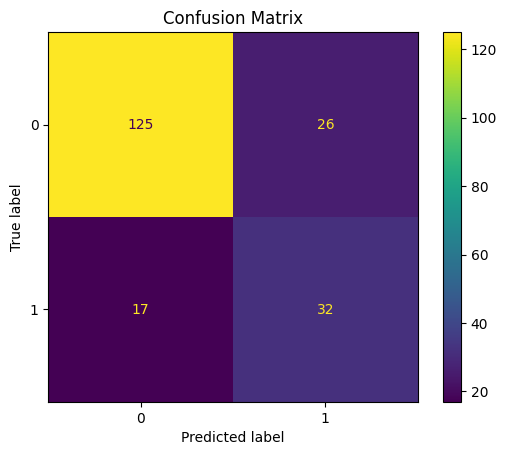

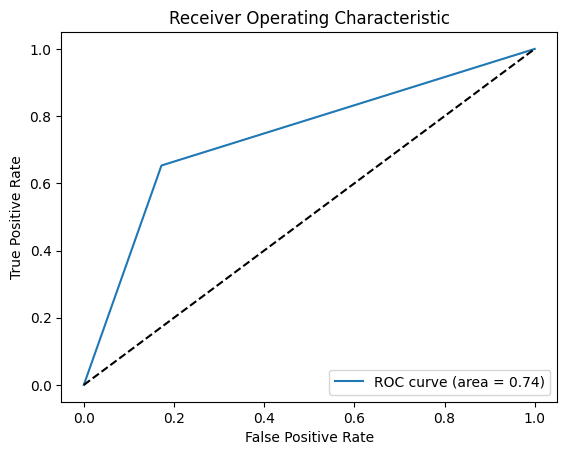

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve (if binary classification and predict_proba is available)
if hasattr(best_model, 'predict_proba'):
    y_score = best_model.predict_proba(X_test)
    # If y_test is 'Y'/'N', convert to binary
    if set(y_test.unique()) == {'Y', 'N'}:
        y_true = (y_test == 'Y').astype(int)
    else:
        y_true = y_test
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
else:
    print('ROC curve not available for this model.')

## 5. Save the Best Model

Save the tuned model pipeline to a file using `joblib`. This serialized model can be loaded later for making predictions.

The entire pipeline—including the `FeatureEngineer`, all preprocessing, and the trained/tuned model—will be saved as one object. 

When we load it later, all the steps will be restored and ready for inference on new data. It can take new raw data (with the same columns and format as our training data). When you call `predict` or `predict_proba` on new data, it will output fraud prediction. No manual preprocessing is needed! 

In [11]:
import os
import joblib

# Define the file path for the saved model
model_path = 'models/dbt_fraud_detection_pipeline.pkl'
os.makedirs('models', exist_ok=True)


# Save the best_model pipeline
joblib.dump(best_model, model_path)

print(f"Model pipeline saved successfully to: {model_path}")

Model pipeline saved successfully to: models/dbt_fraud_detection_pipeline.pkl


## Next Steps and Limitations

### Next Steps
- **Model Sensitivity Analysis:** Explore the impact of different features, algorithms, or hyperparameters on model performance. Consider using the `model_sensitivity_analysis.ipynb` notebook for further experiments.
- **Feature Engineering Enhancements:** Investigate additional domain-specific features or advanced encoding techniques to improve predictive power.
- **Model Monitoring:** Set up monitoring for model drift and data quality in production.
- **Deployment:** Integrate the trained pipeline into a production environment, such as a cloud service or batch scoring system.
- **CI/CD Automation:** Add automated testing and deployment workflows (e.g., GitHub Actions) for reproducibility and reliability.

### Limitations
- **Data Limitations:** The model is only as good as the data provided. If the data is biased or incomplete, predictions may be unreliable.
- **Generalization:** The pipeline is tuned for the current dataset and may require retraining or adjustment for new data sources or changing fraud patterns.
- **Explainability:** AdaBoost and complex pipelines can be less interpretable. Consider adding explainability tools (e.g., SHAP, LIME) for model transparency.
- **Resource Constraints:** Training and inference speed may be limited by hardware or data size, especially with larger datasets or more complex models.